In [1]:
from matplotlib import *
from matplotlib.pyplot import *
import numpy as np
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

model_dir = '../models/'

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

def train_hist(f, new_fig=True, color=[0,1,0], gnuf=.3, a=.5, n_points=-1):
    color = np.asarray(color)
    z = np.load(model_dir + f).item()
    if new_fig:
        sz = 1.5; figure(figsize=(15*sz,4*sz))
    
    n_rows, n_cols = 2, 4
    
    plot_ind = 1
    if n_points == -1:
        n_points = len(z['log']['score_nn'])
    xs = z['log']['opt_batch'][:n_points]
    xse = z['log']['eval_batch'][:n_points]
    
    #### score
    ax = subplot(n_rows,n_cols,plot_ind); plot_ind += 1; simpleaxis(ax)
    plot(xse, z['log']['score_nn'][:n_points], color=color, alpha=a)
    plot(xse, z['log']['score_nn_gnu'][:n_points], linewidth=2, color=color*gnuf, alpha=a)
    axhline(0, color='k', alpha=.25)
    title('Score')
    ylabel('Average score')
    legend(['random opponent','GNU Go opponent'])
    ax.set_xticklabels([])
    
    #### captures
    ax = subplot(n_rows,n_cols,plot_ind); plot_ind += 1; simpleaxis(ax)
    plot(xse, z['log']['n_captures_nn'][:n_points], color=color, alpha=a)
    plot(xse, z['log']['n_captures_opp_nn'][:n_points], color=color, linestyle='--', alpha=a)
    plot(xse, z['log']['n_captures_nn_gnu'][:n_points], linewidth=2, color=color*gnuf, alpha=a)
    plot(xse, z['log']['n_captures_opp_nn_gnu'][:n_points], linewidth=2, color=color*gnuf, linestyle='--', alpha=a)
    axhline(0, color='k', alpha=.25)
    title('Captures')
    ylabel('Average # of captures')
    ax.set_xticklabels([])
    
    #### win
    ax = subplot(n_rows,n_cols,plot_ind); plot_ind += 1; simpleaxis(ax)
    plot(xse, z['log']['win_nn'][:n_points], color=color, alpha=a)
    plot(xse, z['log']['win_nn_gnu'][:n_points], linewidth=2, color=color*gnuf, alpha=a)
    axhline(0.5, color='k', alpha=.25)
    title('Win rate')
    ylabel('Average win rate')
    ax.set_xticklabels([])
    
    keys = ['pol_cross_entrop', 'val_mean_sq_err', 'pol_max', 'val_pearsonr']
    titles = ['Policy cross entropy loss', 'Value mean squared error loss', 'Max policy output', 
              'Predicted vs. actual game scores']
    ylabels = ['Cross entropy', 'Mean squared error', 'Policy output', 'Negative Pearson correlation']
    for key, title_txt, ylabel_txt in zip(keys, titles, ylabels):
        ax = subplot(n_rows,n_cols,plot_ind); plot_ind += 1; simpleaxis(ax)
        plot(xs, z['log'][key][:n_points], color=color, alpha=a)
        title(title_txt)
        ylabel(ylabel_txt)
        xlabel('Training steps')

    suptitle('N_SIM %i   N_TURNS %i' % (z['N_SIM'], z['N_TURNS']))
    return z

psz = 16
pszh = psz / 2
pieces = np.asarray(Image.open('go_pieces.png').resize((psz*2,psz)))[:,:,:3]
piece = [None]*2
piece[1] = pieces[:,:psz] # black
piece[0] = pieces[:,psz:] # white
blank = np.asarray(Image.open('go_blank.png').resize((psz,psz)))[:,:,:3]

# return board as image
def rboard(board):
    n_rows = n_cols = board.shape[0]
    b = np.zeros((psz*n_rows, psz*n_cols, 3), dtype='uint8')
    for i in range(n_rows):
        for j in range(n_cols):
            b[i*psz:(i+1)*psz][:,j*psz:(j+1)*psz] = blank

    for i in range(n_rows):
        b[i*psz + pszh,:] = 1

    for i in range(n_cols):
        b[:, i*psz + pszh] = 1

    for i in range(n_rows):
        for j in range(n_cols):
            if board[i,j] == 0:
                continue
            b[i*psz:(i+1)*psz, j*psz:(j+1)*psz] = piece[1+board[i,j]/2]
    return b

def sboard(board):
    imshow(rboard(board)); axis('off');

def show_game_hist(gm=0, n_turns=20):
    keys = ['nn', 'nn_gnu']
    nms = ['Random opponent:', 'GNU Go opponent:']
    n_rows = len(keys)
    n_cols = np.min((n_turns, z['boards']['nn'].shape[0]))
    plot_ind = 1
    figure(figsize=(23,9))
    for nm, key in zip(nms, keys):
        for c in range(n_cols):
            ax = subplot(2*n_rows,n_cols/2,plot_ind); plot_ind+=1
            if c == 0:
                ax.annotate('%s\n(Score: %i)' % (nm, z['scores'][key][gm]), xy=(0, 0), xytext=(0, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points', size=20, ha='center', va='center')
            sboard(z['boards'][key][c,gm])
            title('Turn %i' % c)
    suptitle('Two example game histories playing against a random opponent and GNU go', fontsize=22, fontweight='bold')
            
def show_end_games(n_turns=20):
    keys = ['nn', 'nn_gnu']
    nms = ['Random opponent:', 'GNU Go opponent:']
    n_rows = len(keys)
    n_cols = n_turns
    plot_ind = 1
    figure(figsize=(23,9))
    for nm, key in zip(nms, keys):
        for c in range(n_cols):
            ax = subplot(n_rows*2,n_cols/2,plot_ind); plot_ind+=1
            if c == 0:
                ax.annotate(nm, xy=(0, 0), xytext=(0, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points', size=20, ha='center', va='center')
            sboard(z['boards'][key][-1,c])
            title('Score: %i' % z['scores'][key][c])
    suptitle('Example terminal game states against a random opponent and GNU go', fontsize=22, fontweight='bold')

# 500 vs 1000 simulations

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


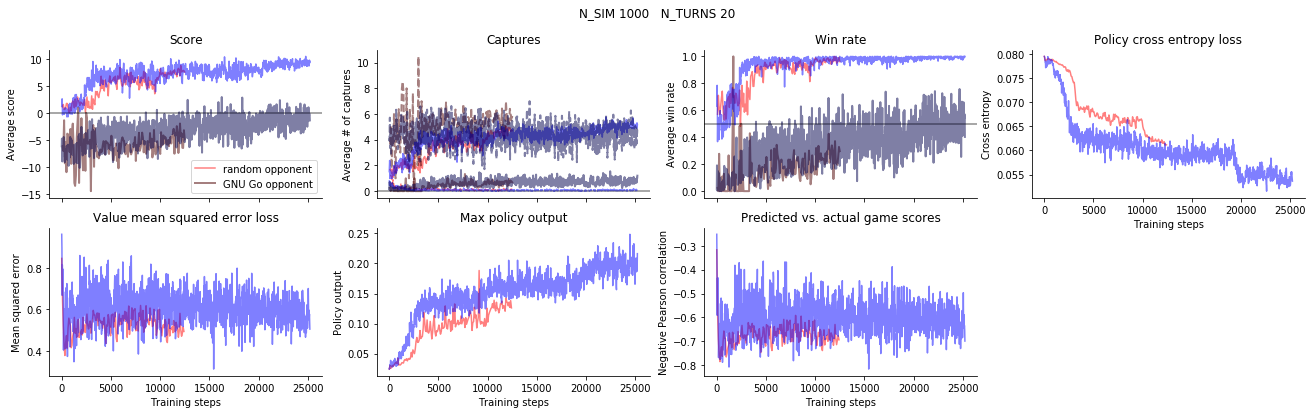

In [2]:
z = train_hist('../../models/go_0.200000EPS_7GMSZ_500N_SIM_0.001000L2_LAMBDA_0.900000MOMENTUM_0.025000VAL_LAMBDA_1.000000CPUCT_20N_TURNS_128N_FILTERS_EPS0.020000_EPS0.020000.npy', color=[1,0,0])
z = train_hist('go_cpu_tree_0.200000EPS_7GMSZ_1000N_SIM_0.001000L2_LAMBDA_0.900000MOMENTUM_0.025000VAL_LAMBDA_1.000000CPUCT_20N_TURNS_128N_FILTERS_EPS0.110000_EPS0.020000_EPS0.010000.npy', color=[0,0,1], new_fig=False)

# 20 vs 10 batch updates per game

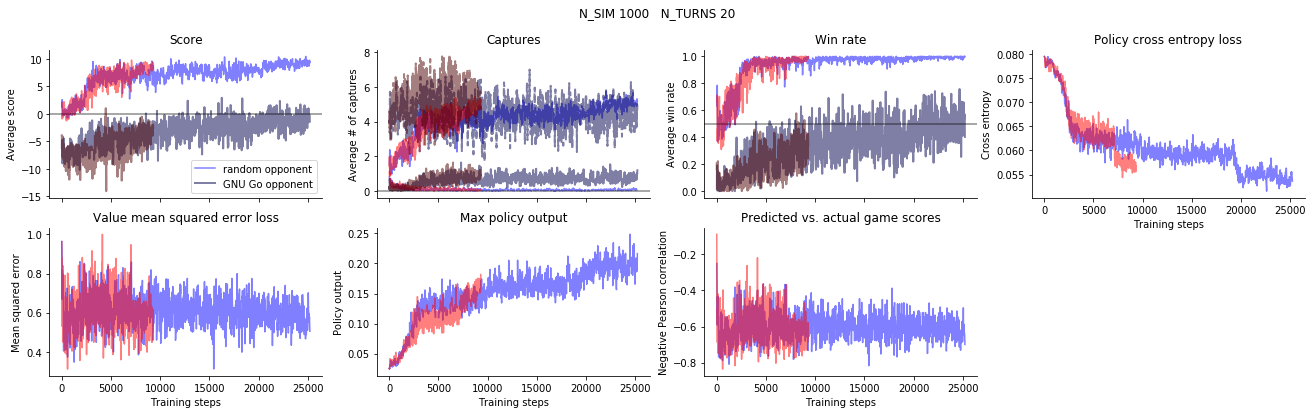

In [3]:
z = train_hist('go_cpu_tree_0.200000EPS_7GMSZ_1000N_SIM_0.001000L2_LAMBDA_0.900000MOMENTUM_0.025000VAL_LAMBDA_1.000000CPUCT_20N_TURNS_128N_FILTERS_EPS0.110000_EPS0.020000_EPS0.010000.npy', color=[0,0,1])
z = train_hist('go_cpu_tree_0.2000EPS_7GMSZ_1000N_SIM_20N_TURNS_128N_FILTERS_0.50N_TURNS_FRAC_TRAIN_EPS0.020000_EPS0.002000.npy', color=[1,0,0], new_fig=False)

# 5 vs 7 layers

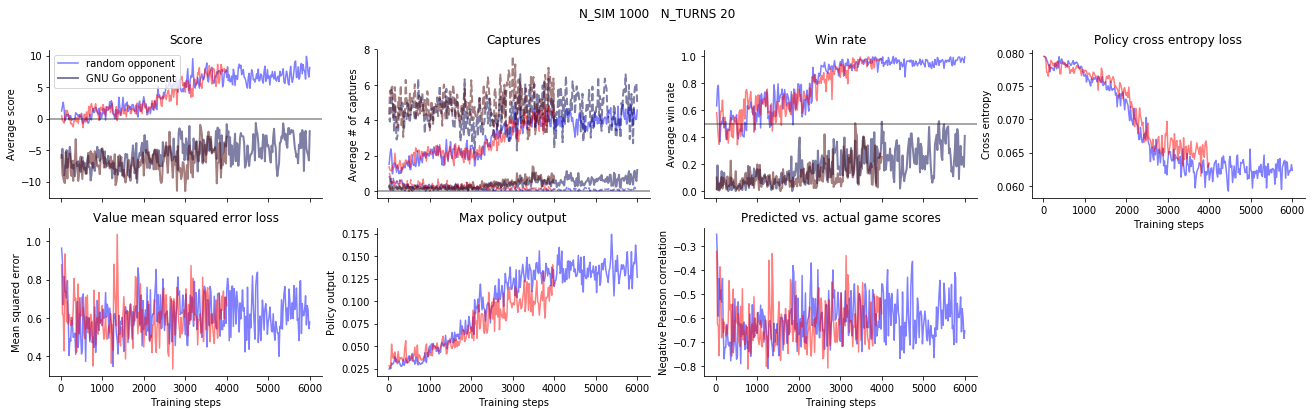

In [4]:
z = train_hist('go_cpu_tree_0.200000EPS_7GMSZ_1000N_SIM_0.001000L2_LAMBDA_0.900000MOMENTUM_0.025000VAL_LAMBDA_1.000000CPUCT_20N_TURNS_128N_FILTERS_EPS0.110000_EPS0.020000_EPS0.010000.npy', color=[0,0,1], n_points=2*150)
z = train_hist('go_cpu_tree_0.2000EPS_7GMSZ_1000N_SIM_20N_TURNS_128N_FILTERS_1.00N_TURNS_FRAC_TRAIN_7N_LAYERS.npy', color=[1,0,0], new_fig=False)

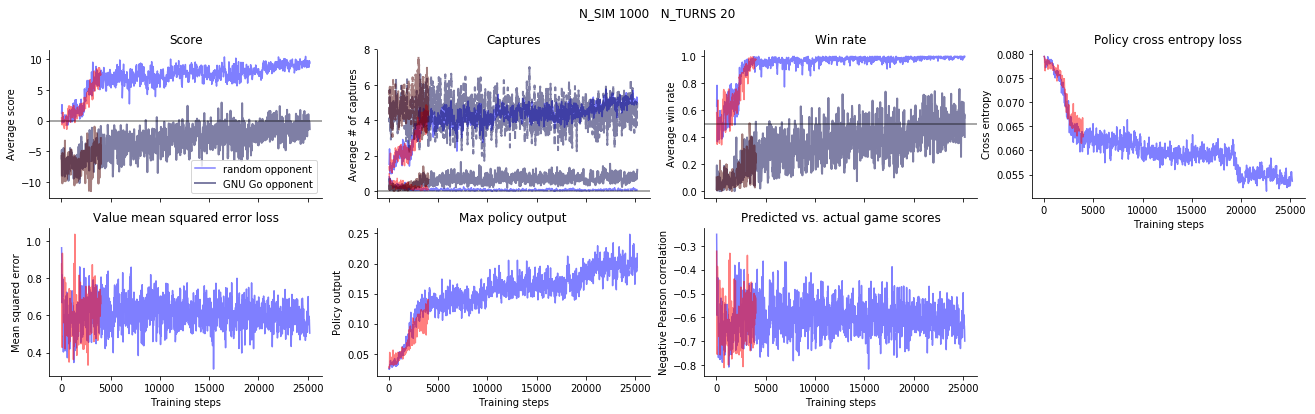

In [5]:
z = train_hist('go_cpu_tree_0.200000EPS_7GMSZ_1000N_SIM_0.001000L2_LAMBDA_0.900000MOMENTUM_0.025000VAL_LAMBDA_1.000000CPUCT_20N_TURNS_128N_FILTERS_EPS0.110000_EPS0.020000_EPS0.010000.npy', color=[0,0,1])
z = train_hist('go_cpu_tree_0.2000EPS_7GMSZ_1000N_SIM_20N_TURNS_128N_FILTERS_1.00N_TURNS_FRAC_TRAIN_7N_LAYERS.npy', color=[1,0,0], new_fig=False)

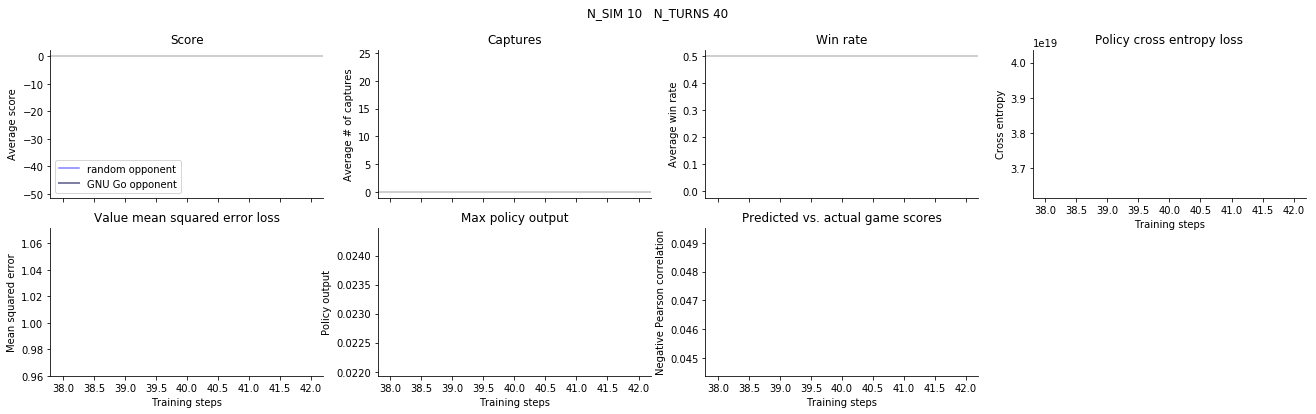

In [15]:
z = train_hist('go_0.0000EPS_7GMSZ_10N_SIM_40N_TURNS_128N_FILTERS_5N_LAYERS.npy', color=[0,0,1])

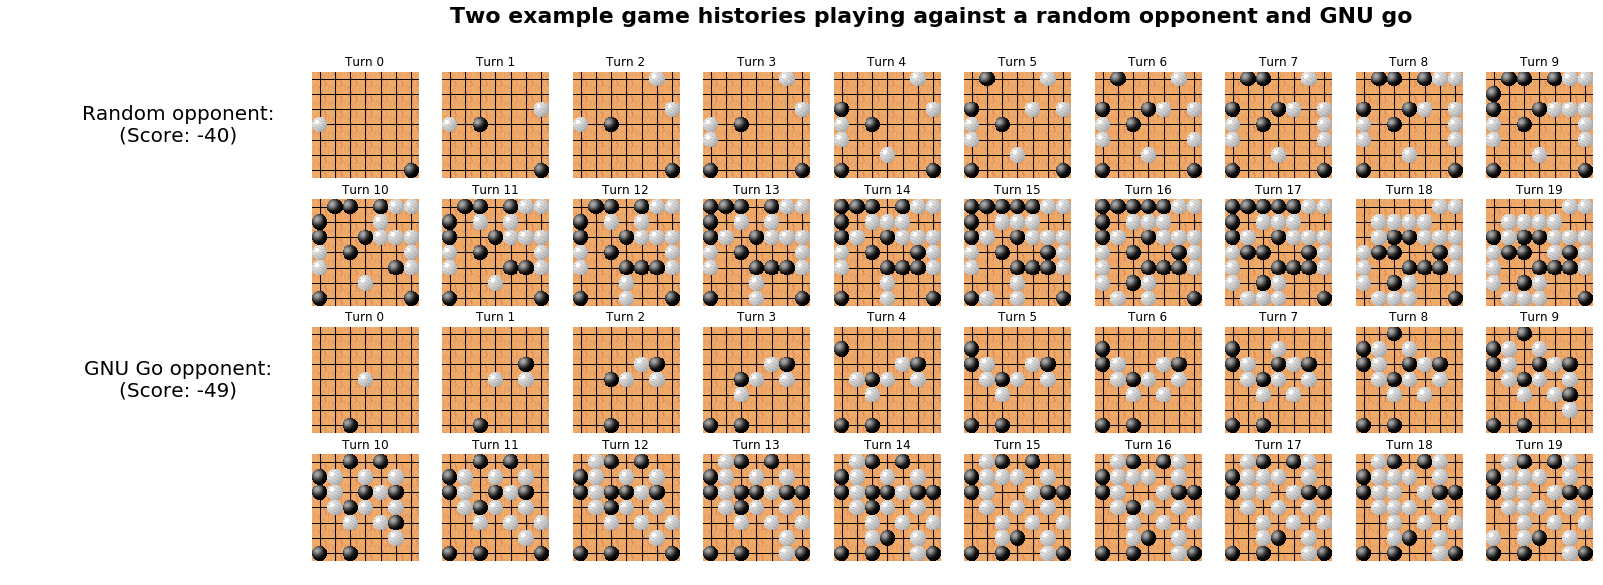

In [16]:
show_game_hist(gm=0)

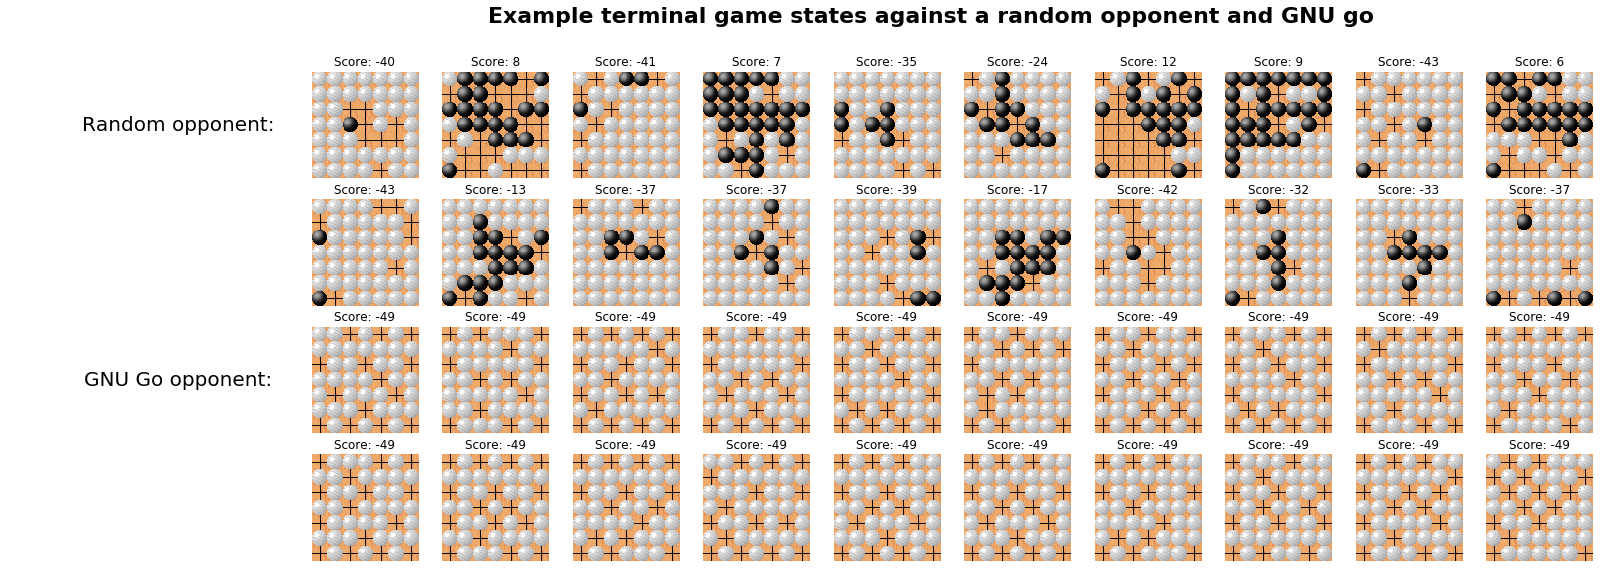

In [17]:
show_end_games()